In [110]:
import pandas as pd
import os
from pathlib import Path
from scipy.stats import ranksums
import matplotlib.pyplot as plt
import seaborn as sns

In [111]:
DL = ['DenseNet201', 'MobileNetV2', 'InceptionV3', "ResNet50"]
ML = ['GradientBoosting', 'KNN', 'NBayes', "RandomForest"]
COLUMNS = ["val_accuracy", "val_precision", "val_specificity", "val_f1_score", "val_auc", "val_npv", "val_mcc"]
SUBSETS = ['Dataset01_100', 'Dataset01_95.0', 'Dataset01_90.0', 'Dataset01_85.0', 'Dataset01_80.0', 'Dataset01_75.0', 
           'Dataset01_70.0', 'Dataset01_65.0', 'Dataset01_60.0', 'Dataset01_55.0', 'Dataset01_50.0', 'Dataset01_45.0',
           'Dataset01_40.0', 'Dataset01_35.0', 'Dataset01_30.0', 'Dataset01_25.0', 'Dataset01_20.0', 'Dataset01_15.0', 
           'Dataset01_10.0', 'Dataset01_5.0']


In [112]:
path_project = Path().absolute().parent.parent.parent
results_path = path_project / "6_resultados"

output = results_path / "analitycs" / "by_test"

In [113]:
import pandas as pd
import os
from pathlib import Path

# Define paths
path_project = Path().absolute().parent.parent.parent
results_path = path_project / "6_resultados"

# DataFrame to hold all results
all_results = []

# Process each network and subset
for network in DL + ML:
    for subset in SUBSETS:
        # Define the path for CSV files
        metrics_path = results_path / subset / network / "metrics"
        if network in DL:
            csvs_path = metrics_path / "csvs" / '_refined'
        else:
            csvs_path = metrics_path
        
        # List all files in the directory
        if csvs_path.exists() and csvs_path.is_dir():
            csv_files = [f for f in csvs_path.iterdir() if f.is_file()]
            
            # Read each file and append to the list
            for csv_file in csv_files:
                try:
                    df = pd.read_csv(csv_file)
                    df['Model'] = network
                    df['Subset'] = subset
                    all_results.append(df)
                except Exception as e:
                    print(f"Error reading {csv_file}: {e}")

# Concatenate all DataFrames
result = pd.concat(all_results, ignore_index=True)
result.head()


,dataset,network,DenseNum,DropOut,FreezePercentage,BatchSize,epoch,accuracy,precision,sensitivity,...,val_mcc,val_auc,val_TP,val_TN,val_FP,val_FN,val_runtime,Model,Subset,partition
0,100,DenseNet201,128.0,0.3,0.3,64.0,9.0,1.000000,1.000000,1.000000,...,0.986026,0.998105,1208.0,1207.0,9.0,8.0,16.186918,DenseNet201,Dataset01_100,NaN
1,100,DenseNet201,128.0,0.3,0.3,64.0,1.0,0.992582,0.992787,0.991946,...,0.969590,0.996889,1199.0,1196.0,20.0,17.0,14.723663,DenseNet201,Dataset01_100,NaN
2,100,DenseNet201,128.0,0.3,0.3,64.0,7.0,1.000000,0.999788,1.000000,...,0.973697,0.997883,1200.0,1200.0,16.0,16.0,14.152358,DenseNet201,Dataset01_100,NaN
3,100,DenseNet201,128.0,0.3,0.3,64.0,4.0,1.000000,1.000000,1.000000,...,0.968763,0.994513,1134.0,1134.0,18.0,18.0,15.219777,DenseNet201,Dataset01_100,NaN
4,100,DenseNet201,128.0,0.3,0.3,64.0,0.0,0.956250,0.950073,0.951458,...,0.967066,0.992782,1130.0,1136.0,16.0,22.0,15.515041,DenseNet201,Dataset01_100,NaN


In [114]:
#  Análise estatística (teste de hipótese)
#  hipotese: quero provar que a variação das ROI's influencia no desempenho e métricas dos modelos de redes neurais
#  hipotese nula (H0): as métricas de desempenho dos modelos de redes neurais são iguais entre cada subconjunto de dados (SUBSETS -> ROIS)
#  hipotese alternativa (H1): as métricas de desempenho dos modelos de redes neurais são diferentes entre cada subconjunto de dados (SUBSETS -> ROIS)
# alpha = 0.01, 1% de significância, de concluir que a hipótese nula é falsa quando ela é verdadeira.
# Valor-p (p-value)
## Se p-value < alpha: rejeita-se a hipótese nula (temos evidências suficientes para rejeitar a hipótese nula) (0) (green)
## Se p-value >= alpha: não rejeita-se a hipótese nula (não temos evidências suficientes para rejeitar a hipótese nula) (1) (red)
# Teste de hipótese: ranksums (teste de Mann-Whitney)



In [115]:
# modifiy code above to create a function that receives a dataframe and a roi and return a dataframe with p_values

def test_hyphotesis(main_pd, roi, alpha=0.01):
    """
    Função para testar a hipótese nula de que as métricas de desempenho dos modelos de redes neurais são iguais entre cada subconjunto de dados (SUBSETS -> ROIS).
    em relação a 100% de ROI.
    :param main_pd: DataFrame contendo todos os dados.
    :param roi: Tamanho da ROI (int).
    :return: DataFrame contendo os p-values de cada métrica para cada modelo de rede neural.
    """
    normalized_values = pd.DataFrame()
    for network in main_pd['network'].unique():
        network_data = main_pd[main_pd['network'] == network]
        roi_data = network_data[network_data['dataset'] == roi]
       
        # make for all atributtes
        for column in COLUMNS:
            # em comparação com 100% de ROI
            p_value = ranksums(roi_data[column], network_data[network_data['dataset'] == 100][column], alternative='two-sided').pvalue
            if p_value < alpha:
                h = 0
            else:
                h = 1
            normalized_values = normalized_values._append({'network': network, 'roi': roi, 'column': column, 'p_value': p_value, 'h': h}, ignore_index=True)
        
    return normalized_values

result_p_values = pd.DataFrame()
for roi in result['dataset'].unique():
    result_p_values = pd.concat([result_p_values, test_hyphotesis(result, roi)], ignore_index=True)

result_p_values.to_csv(output / "p_values.csv", index=False)


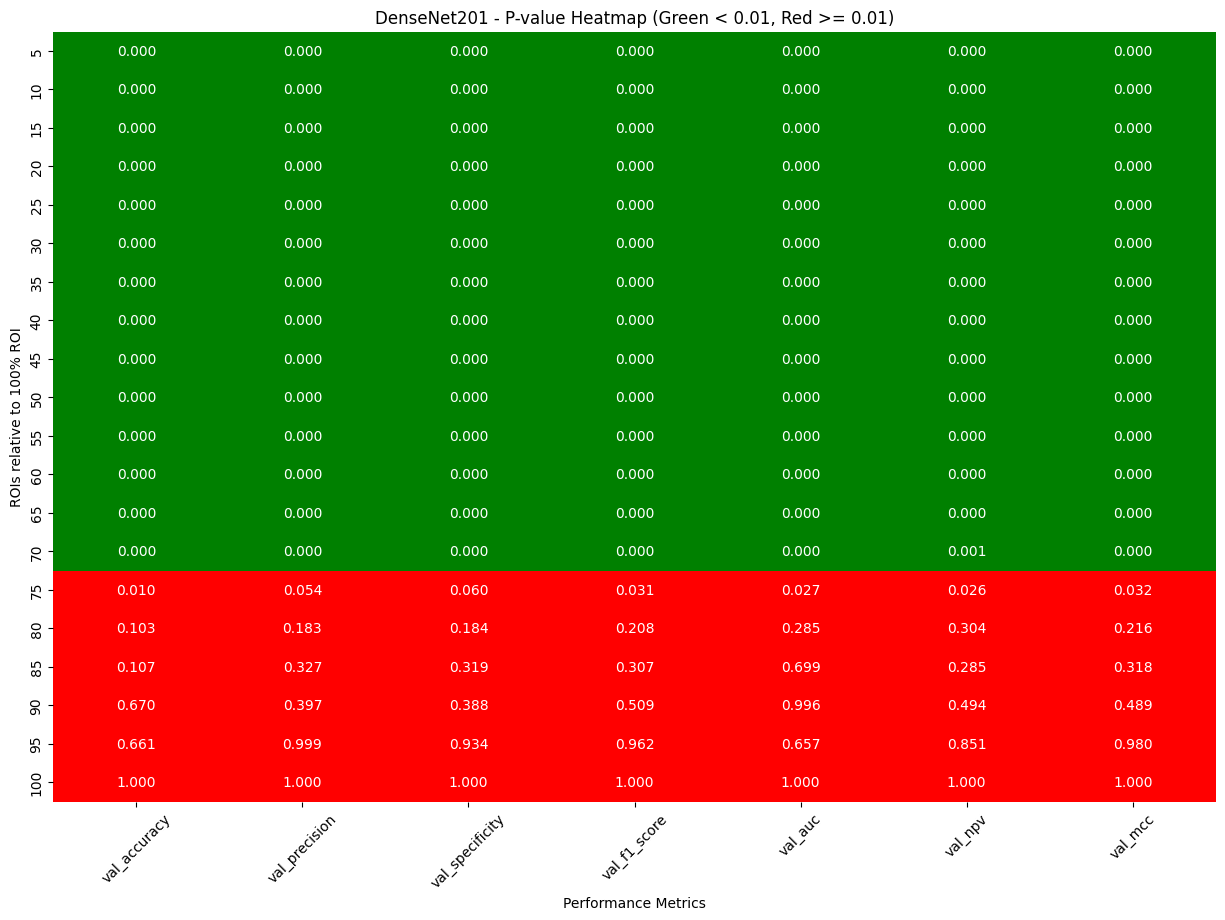

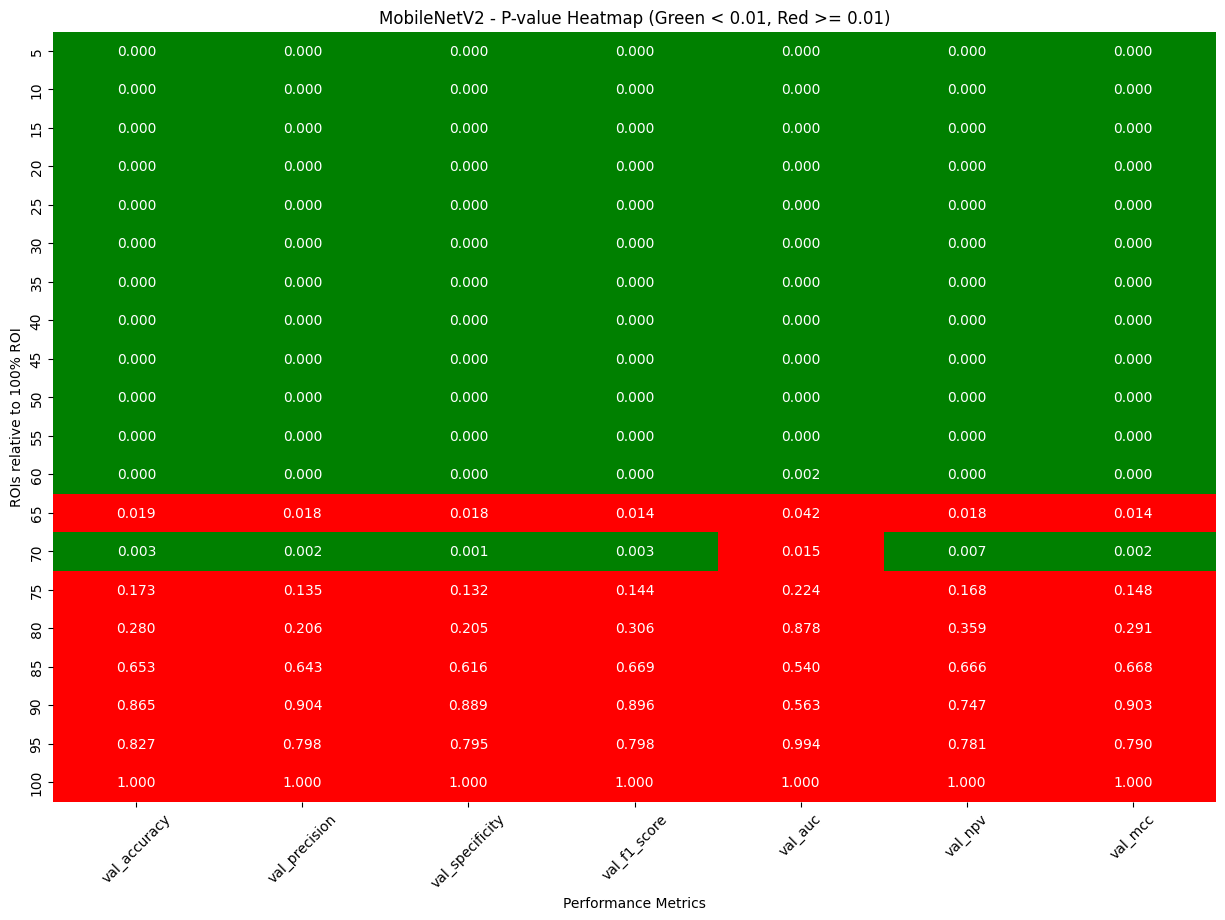

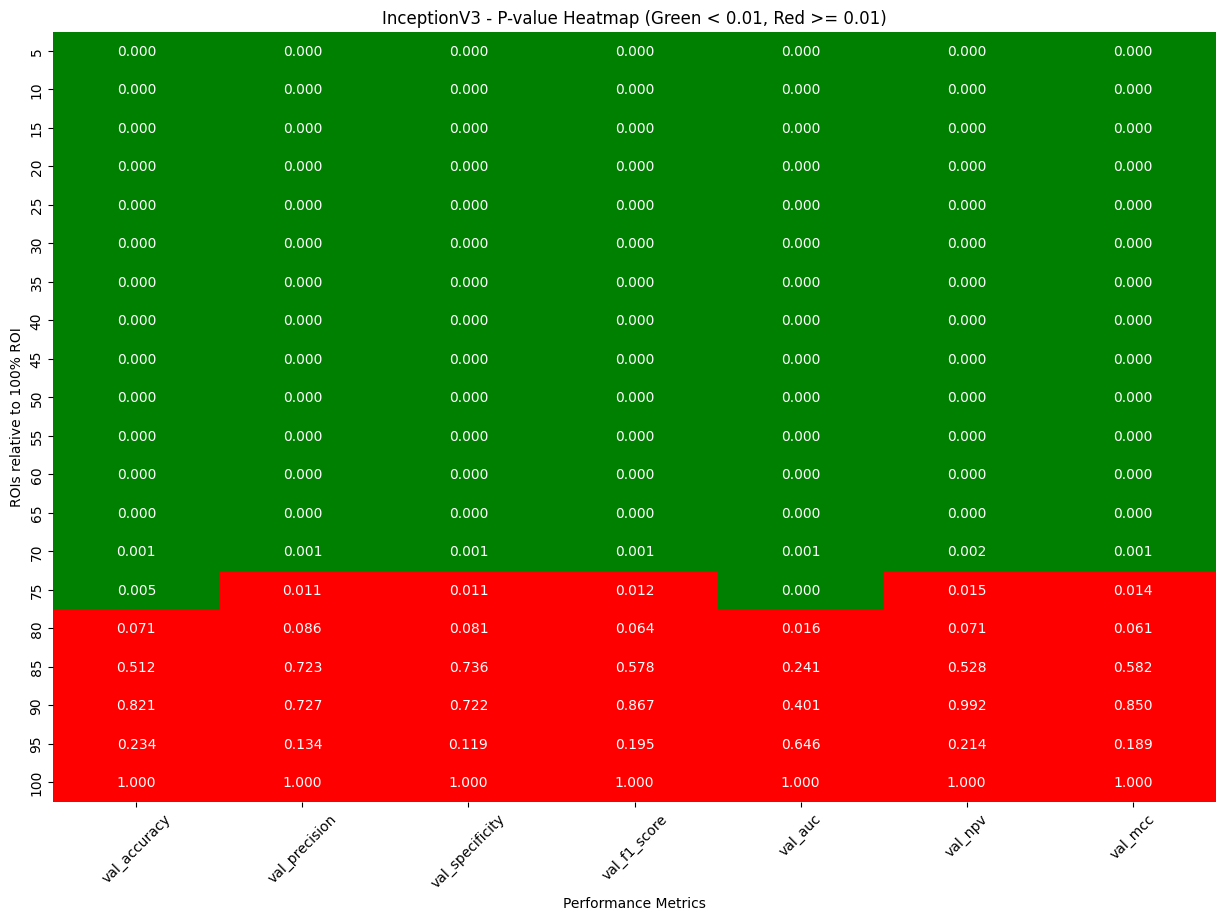

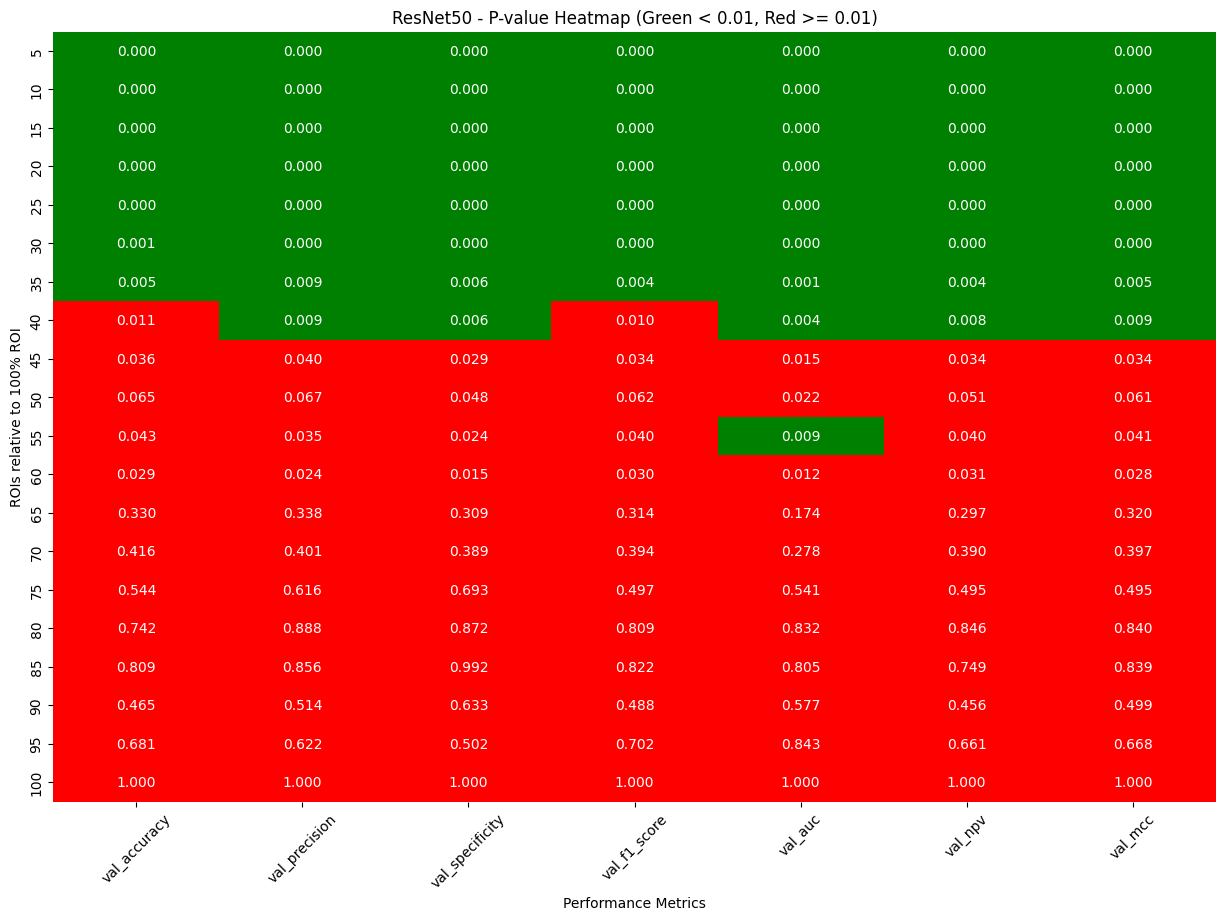

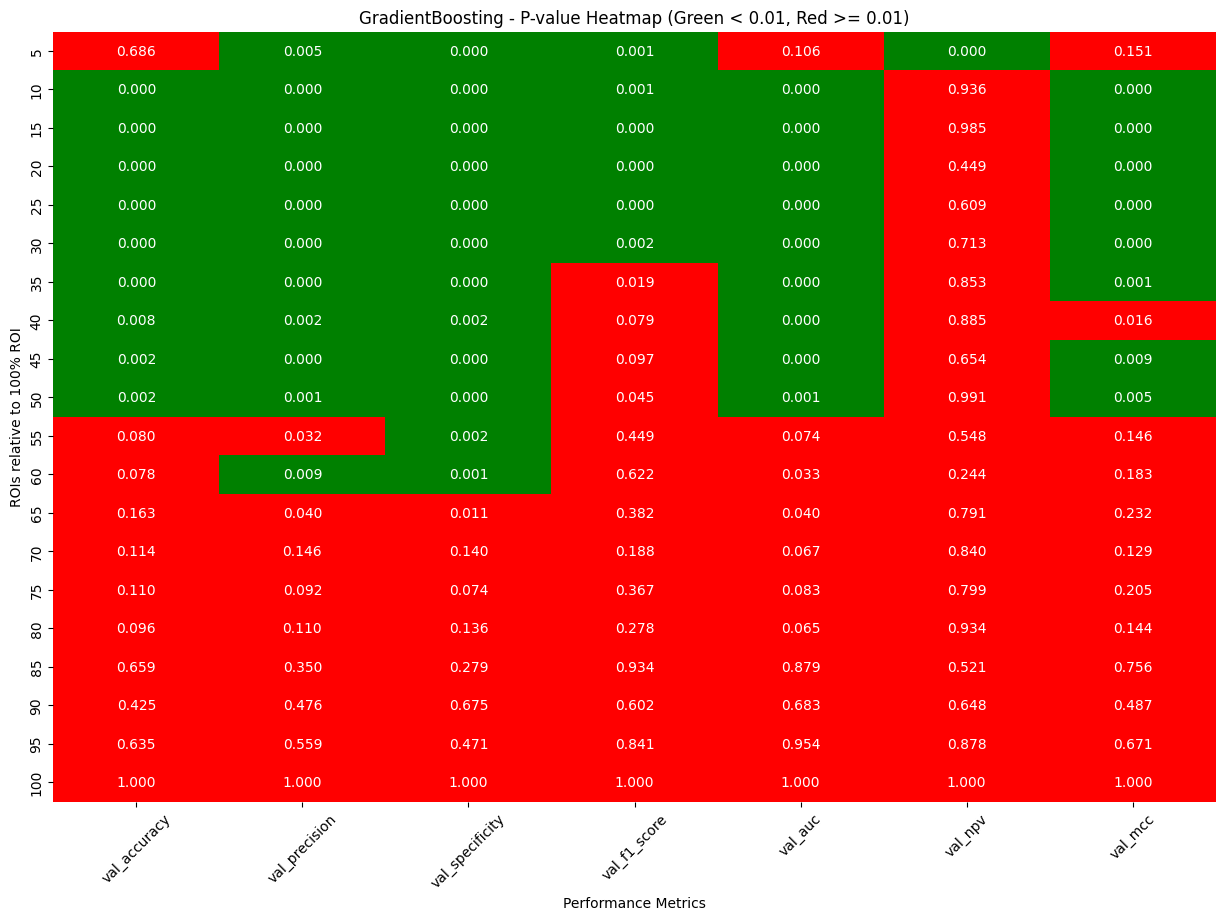

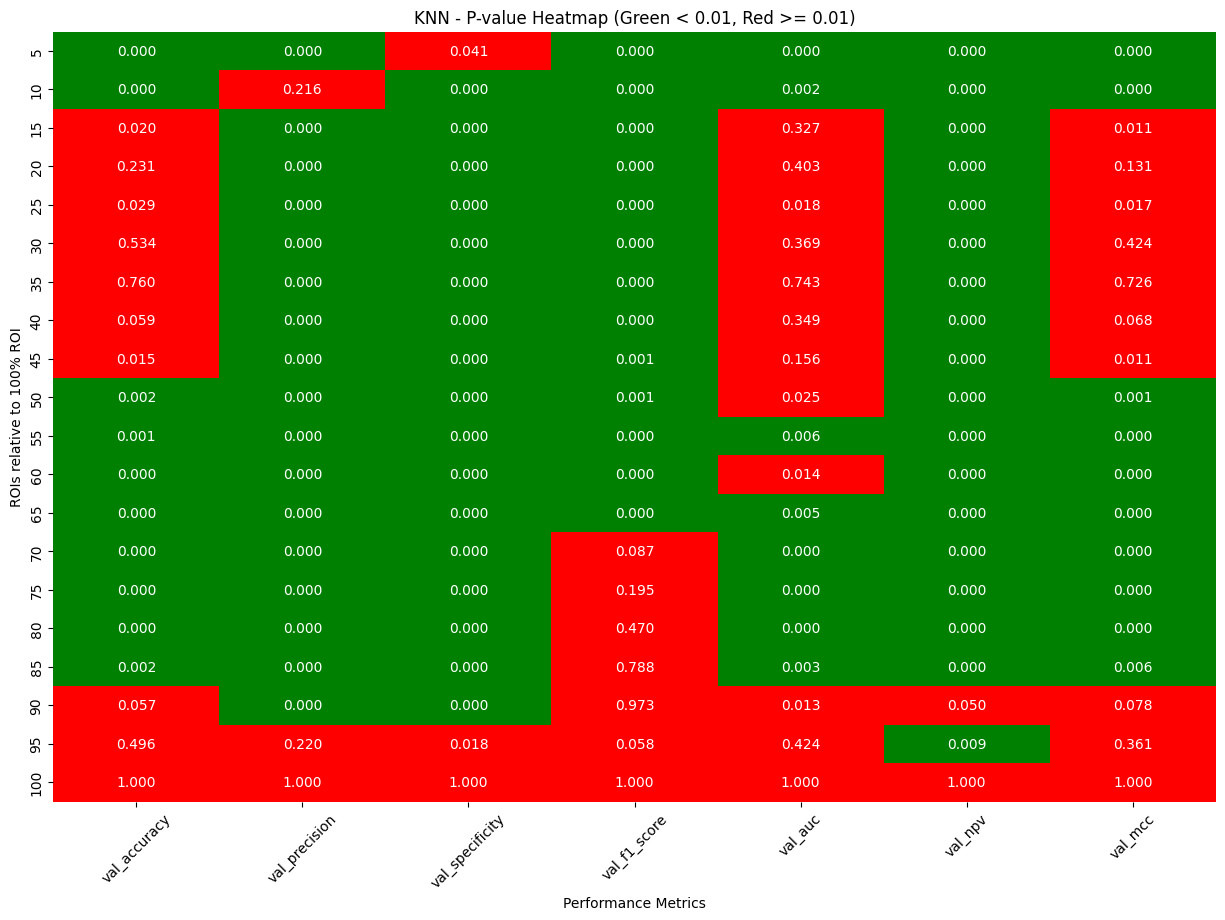

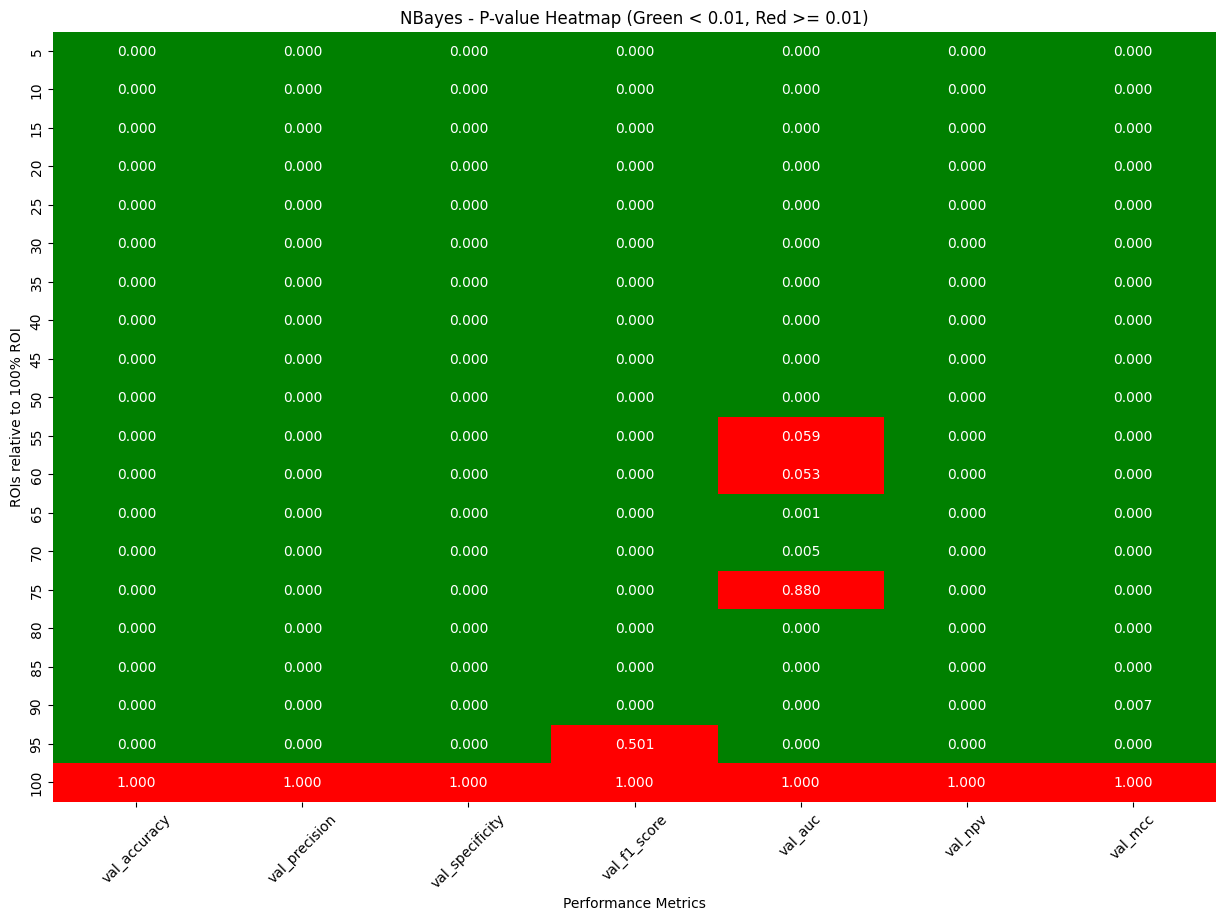

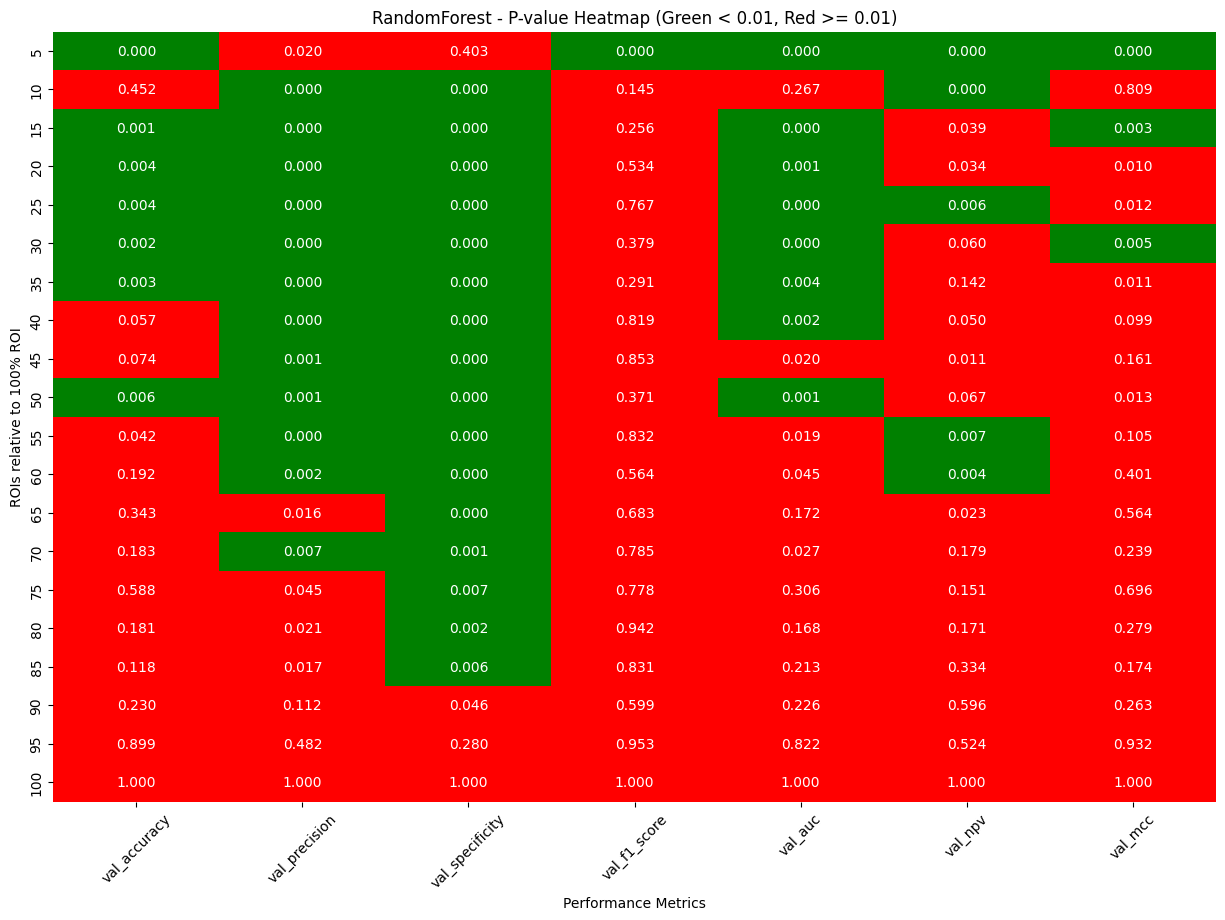

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

# Load the p_values data
result_p_values = pd.read_csv(output / "p_values.csv")

# Define a custom colormap: green for significant (p < 0.01), red for not significant
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['red', 'green'])

# Iterate over each network to plot heatmaps
for network in result_p_values['network'].unique():
    network_data = result_p_values[result_p_values['network'] == network]
    network_data = network_data.pivot(index='roi', columns='column', values='p_value')
    network_data = network_data[COLUMNS]
    network_data = network_data.round(3)

    # Define a binary matrix for significance
    significant = (network_data < 0.01).astype(int)

    plt.figure(figsize=(15, 10))
    sns.heatmap(significant, annot=network_data.values, fmt=".3f", cmap=cmap, cbar=False)
    plt.title(f"{network} - P-value Heatmap (Green < 0.01, Red >= 0.01)")
    plt.xticks(rotation=45)
    plt.xlabel("Performance Metrics")
    plt.ylabel("ROIs relative to 100% ROI")

    # Ensure the output directory exists
    output_dir = output 
    plt.savefig(output_dir / f"{network}.png")
    plt.show()


In [117]:
import pandas as pd
import matplotlib.pyplot as plt
order = ["val_accuracy", "val_precision", "val_specificity", "val_f1_score", "val_auc", "val_npv", "val_mcc"]

# Assume result_p_values is already loaded as described in previous examples
# Adding a column to indicate rejection (where h = 0 means reject H0)
result_p_values['Rejected'] = result_p_values['h'].apply(lambda x: 1 if x == 0 else 0)

# Calculate the rejection rate for each combination of network and ROI
rejection_rates = result_p_values.groupby(['network', 'roi']).agg(
    Total_Tests=pd.NamedAgg(column='h', aggfunc='count'),
    Total_Rejections=pd.NamedAgg(column='Rejected', aggfunc='sum')
).reset_index()

rejection_rates['Rejection_Rate'] = rejection_rates['Total_Rejections'] / rejection_rates['Total_Tests']


# Identify the minimum ROI for each network with the highest rejection rate
max_rejection_rois = rejection_rates.loc[rejection_rates.groupby('network')['Rejection_Rate'].idxmax()]
# Filter result_p_values for these optimal combinations
optimal_data = result_p_values[
    result_p_values.apply(lambda x: (x['network'], x['roi']) in list(zip(max_rejection_rois['network'], max_rejection_rois['roi'])), axis=1)
]

# Pivot the DataFrame
pivot_df = optimal_data.pivot_table(index=['network', 'roi'], columns='column', values='p_value', aggfunc='first').reset_index()

# Prepare the table data
columns = ['Model', 'ROI'] + order
cell_text = []
for _, row in pivot_df.iterrows():
    roi_with_percent = f"{row['roi']}%"
    row_data = [row['network'], roi_with_percent] + [f"{row[metric]:.3f}" for metric in pivot_df.columns if metric not in ['network', 'roi']]
    cell_text.append(row_data)

# save new csv
rejection_rates.to_csv(output / "rejection_rates.csv", index=False)

# Assuming the DataFrame `pivot_df` and `cell_text` preparation is done as in previous steps


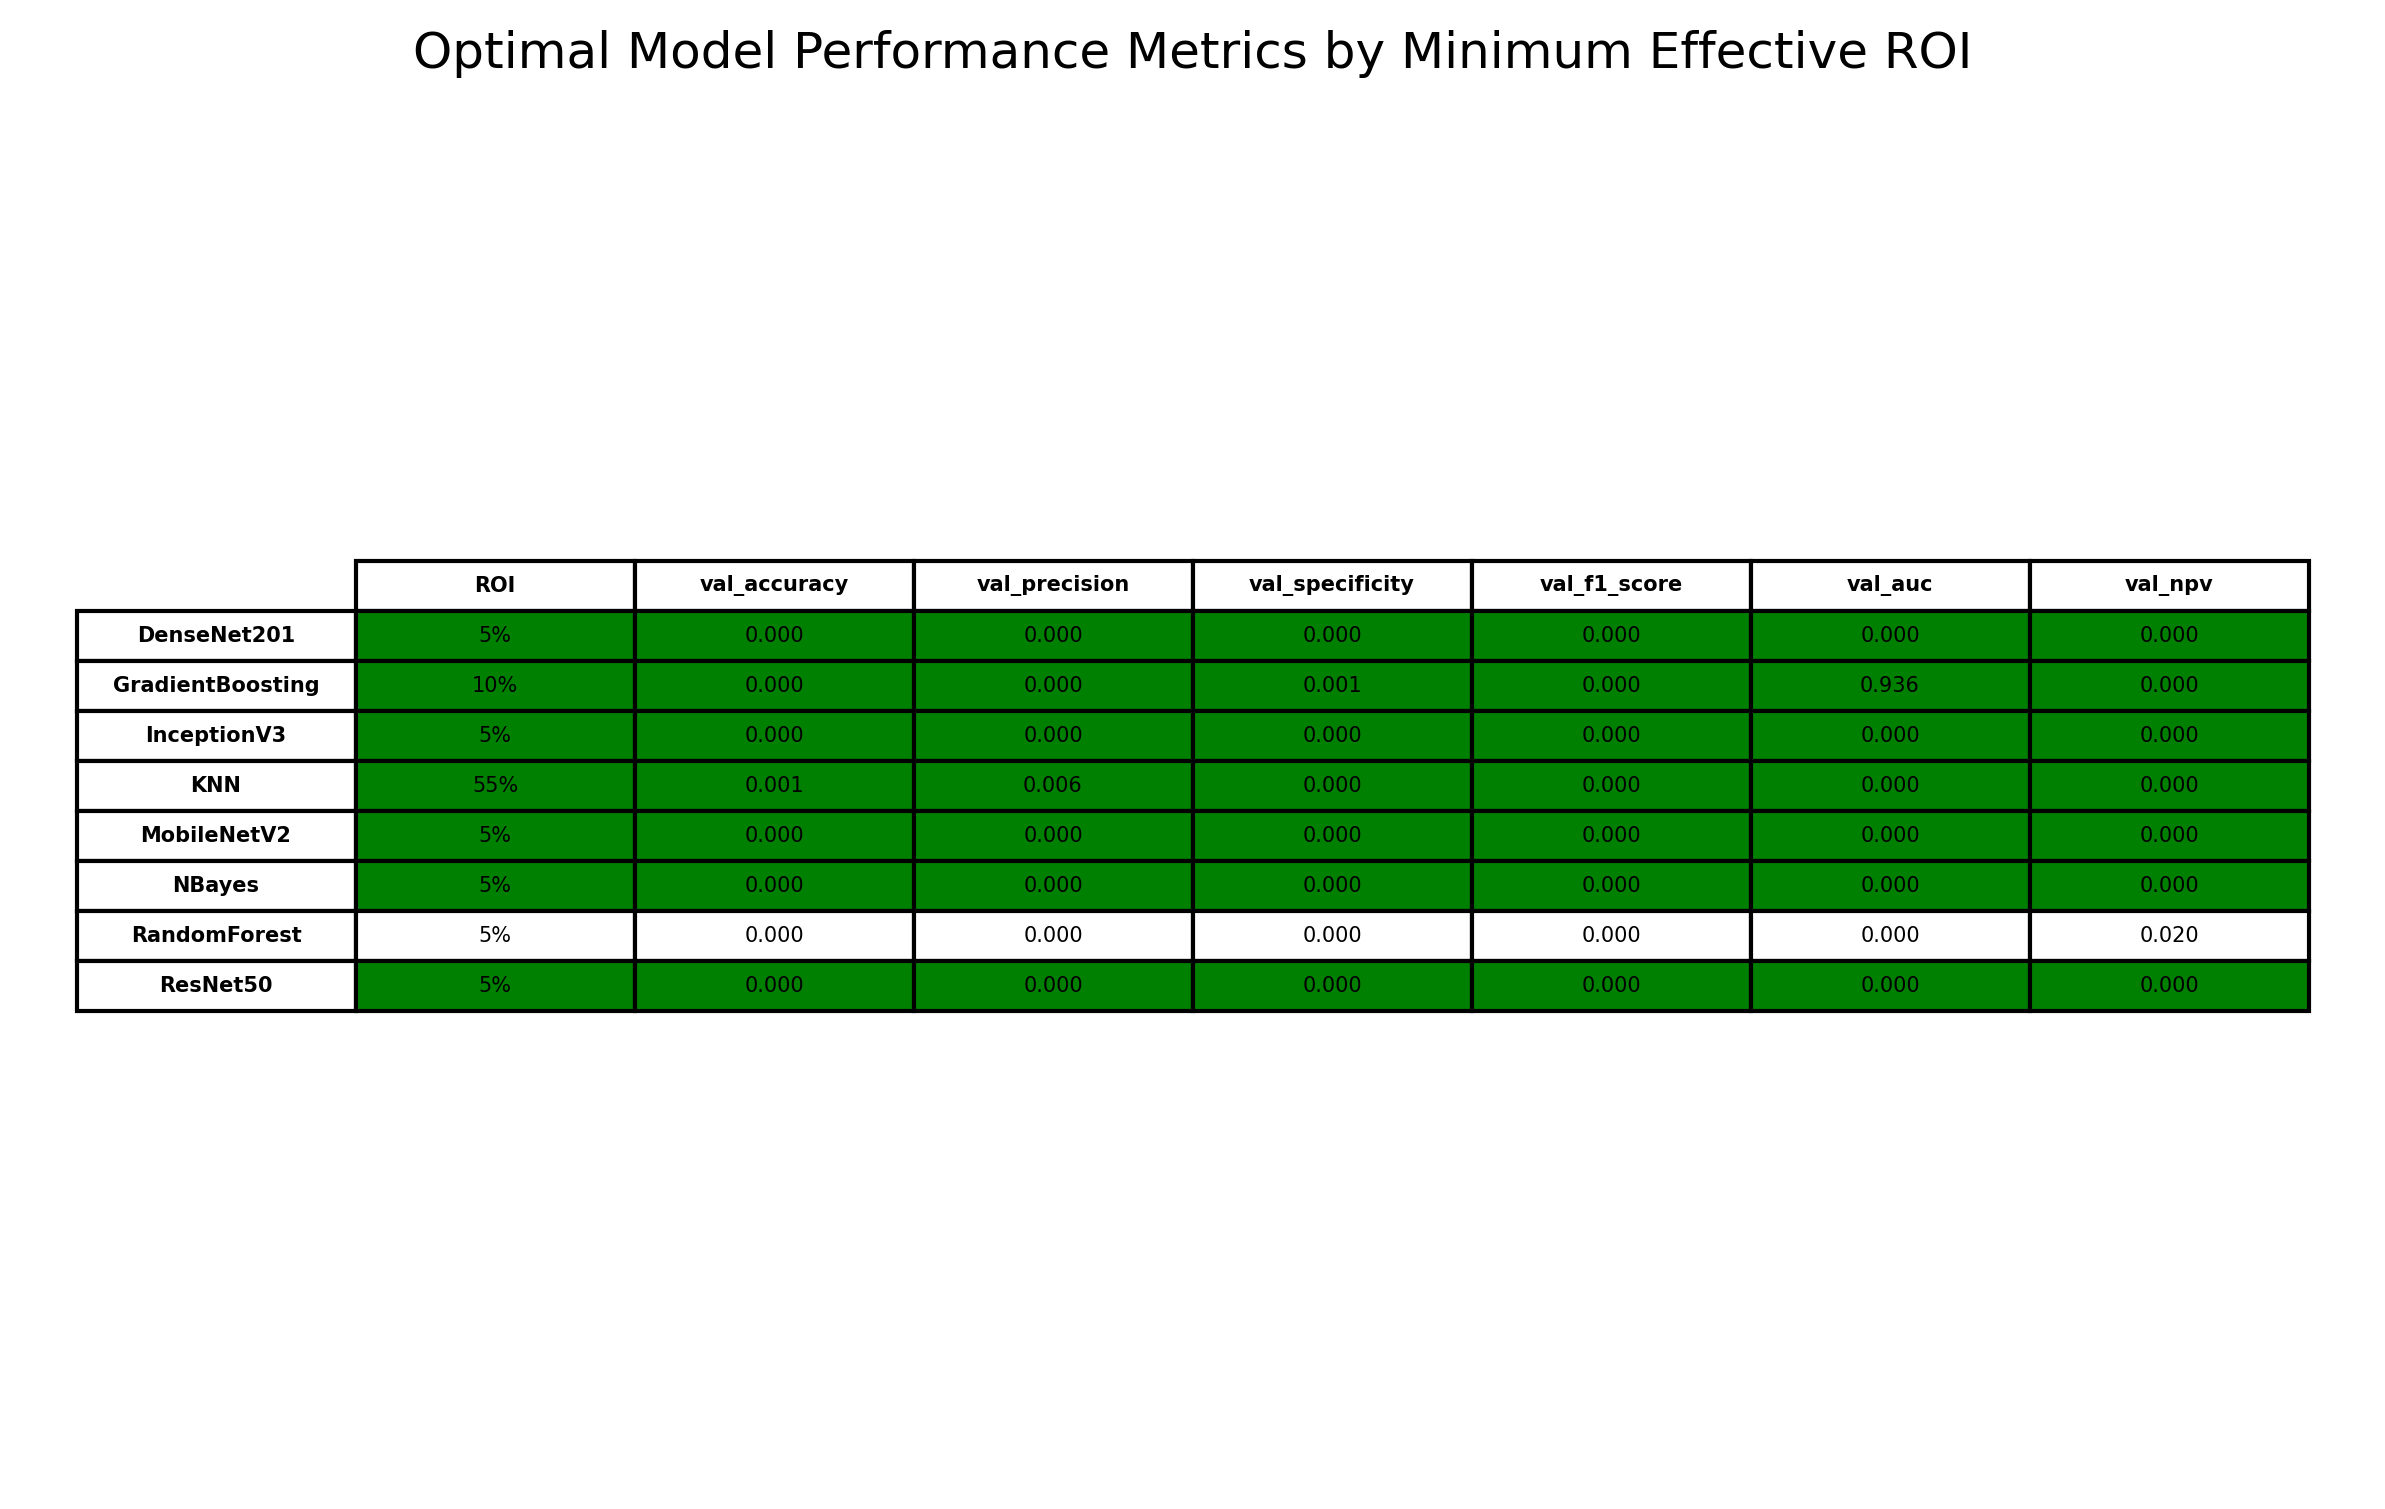

In [129]:
import matplotlib.pyplot as plt

# Assume cell_text and columns are already prepared and include a 'Rejected' indicator
# Example: cell_text might include rows like [network, roi, val_accuracy (p-value), rejected_indicator, ...]

# Create the figure and axis with higher DPI for better resolution
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
ax.axis('tight')
ax.axis('off')

# Set font size globally for the table
plt.rcParams.update({'font.size': 10, 'text.color': 'black'})

# Create the table
the_table = plt.table(cellText=[row[:-1] for row in cell_text],  # Excluding the 'Rejected' column from display
                      colLabels=columns,
                      cellLoc='center',
                      loc='center',
                      colWidths=[0.12] * len(columns))

# Modify cell properties
for (i, j), cell in the_table.get_celld().items():
    if i > 0:  # Skip header
        # Set the text color to blue if the hypothesis was rejected
        if cell_text[i-1][j] == 1:  # Assuming the last column in cell_text indicates rejection
            cell.get_text().set_color('blue')

    if i == 0 and j == 0:  # Remove text and border from 'Model' header cell
        cell.set_visible(False)

    if i == 0 and j != 0:  # Adjust header properties
        cell.set_fontsize(12)
        cell.set_text_props(weight='bold')
        cell.set_linewidth(1)

    if i != 0 and j == 0:  # Adjust row header properties
        cell.set_fontsize(12)
        cell.set_text_props(weight='bold')
        cell.set_linewidth(1)
    
    if i != 0 and j != 0:  # Adjust data cell properties
        cell.set_fontsize(10)
        cell.set_linewidth(1)
    

# Calculate the middle of the attributes columns and draw a vertical line
num_attributes = len(columns) - 1
mid_index = num_attributes // 2 + 0.5 if num_attributes % 2 == 0 else num_attributes // 2 + 1
x_pos = (mid_index + 0.5) / num_attributes

# Draw the line splitting attributes into two groups
plt.axvline(x=x_pos, color='black', linestyle='-', linewidth=1)

plt.title('Optimal Model Performance Metrics by Minimum Effective ROI')
plt.show()

# Save the figure
fig.savefig('hyphotesis_table.png', bbox_inches='tight', dpi=300)
